# Determining Transport and Capillary Properties from Images
---
It is becoming increasingly common to perform simulations directly on an image, using the voxels as the computational mesh.  

PoreSpy offers some limited functionality in this area:
- Effective diffusivity, aka formation factor or tortuosity
- Drainage simulations, aka mercury intrusion porosimetry
- Invasion percolation

PoreSpy currently does *not* have (but are working on):
- Permeability (Navier-Stokes equations e much harder than the Laplace equation)
- Imbibition

In [17]:
import porespy as ps
import matplotlib.pyplot as plt
import numpy as np

## Tortuosity
---
Tortuosity is a fitting factor to account for the reduction of diffusion rate beyond the effect of porosity.  It is defined as:

$$ \frac{ D_{eff} }{ D_{bulk} } = \frac{\varepsilon}{\tau} $$

- $D_{eff}$ is some fraction of coefficient in open space (i.e. $D_{eff}/D_{bulk} < 1.0$)
- The reduction in $D_{eff}$ is *at least* equal to the reduced pore volume (i.e. $D_{eff}/D_{bulk} < \varepsilon$)
- But there is an additional reduction since the diffusing molecules are not able to move *directly* across the domain
- This additional resistance is called *tortuosity*

Let's generate a 2D test image

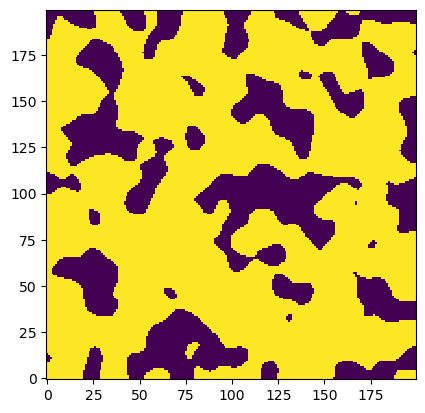

In [18]:
np.random.seed(0)
im = ps.generators.blobs([200, 200], porosity=0.7)
plt.imshow(im, origin='lower', interpolation='none');

### Preparing the Image
---
A few problems with this image:

- There are several 'blind pores' which will cause problems for the numerical solver
- There are also several pores on the edges which are not connected to the main percolating path

PoreSpy has functions for cleaning this up:

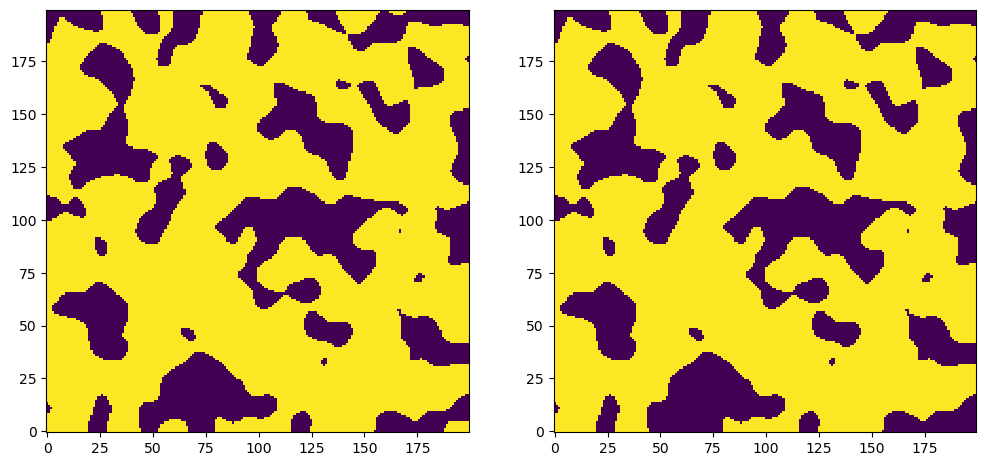

In [19]:
im1 = ps.filters.fill_blind_pores(im)
fig, ax = plt.subplots(1, 2, figsize=[12, 6])
ax[0].imshow(im1, origin='lower', interpolation='none')

im2 = ps.filters.fill_blind_pores(im, surface=True)
ax[1].imshow(im2, origin='lower', interpolation='none');

### Calling the Function
---
Now we are ready to analyze this image.

In [20]:
tau_x = ps.simulations.tortuosity_fd(im2, axis=0)
tau_y = ps.simulations.tortuosity_fd(im2, axis=1)

The returned objects contain several pieces of data as attributes, including the calculated tortuosity value, which we can inspect by printing:

In [21]:
print(tau_x)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Item                      Description
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im                        Image of size (200, 200)
tortuosity                1.8569242614864547
formation_factor          2.6298318389554662
original_porosity         0.7061
effective_porosity        0.7061
concentration             Image of size (200, 200)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


And we can inspect the concentration distribution:

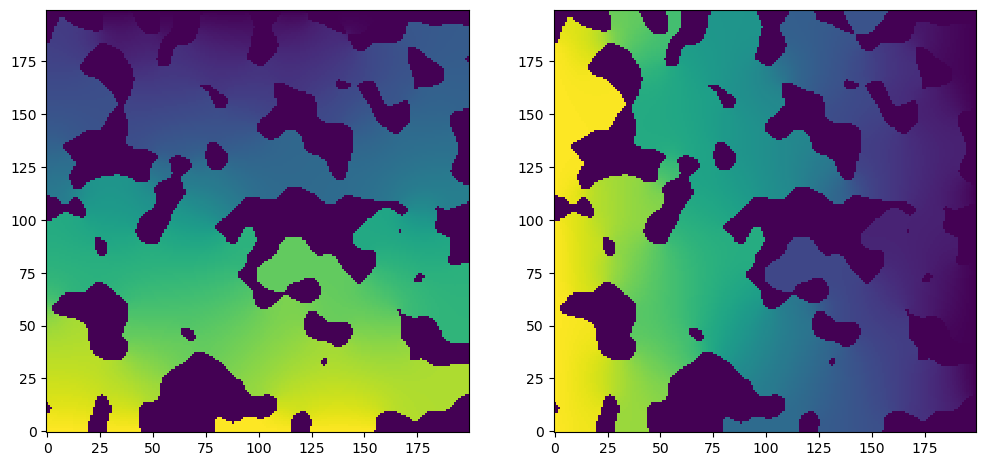

In [22]:
fig, ax = plt.subplots(1, 2, figsize=[12, 6])
ax[0].imshow(tau_x.concentration, origin='lower', interpolation='none')
ax[1].imshow(tau_y.concentration, origin='lower', interpolation='none');

## Drainage and Porosimetry
---
The invasion of a non-wetting fluid can be simulated by drawing spheres with a radius correponding to the applied capillary pressure:

$$ R = -2 \sigma \frac{cos(\theta)}{P_C} $$

This allows us to insert spheres of size $R$ to determine where the fluid will invaded at a given $P_C$.  

The *only difference* between this simulation and the ``local_thickness`` filter covered in the previous section is that the fluid invasion is "access limited".  

In [23]:
mip = ps.simulations.drainage(im, sigma=0.465, theta=140, voxel_size=1e-5)
print(mip)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Item                      Description
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im_satn                   Image of size (200, 200)
im_pc                     Image of size (200, 200)
im_trapped                None
pc                        Array of size (11,)
snwp                      [0.0, 0.2760524742376816, 0.6157633735448247, 0.889318749340555, 0.9173143882108817, 0.9220975626912391, 0.9847360461435656, 0.9884992790067879, 0.9909260366475574, 0.9977490943621848, 0.9977490943621848]
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


And we can plot the results as follows:

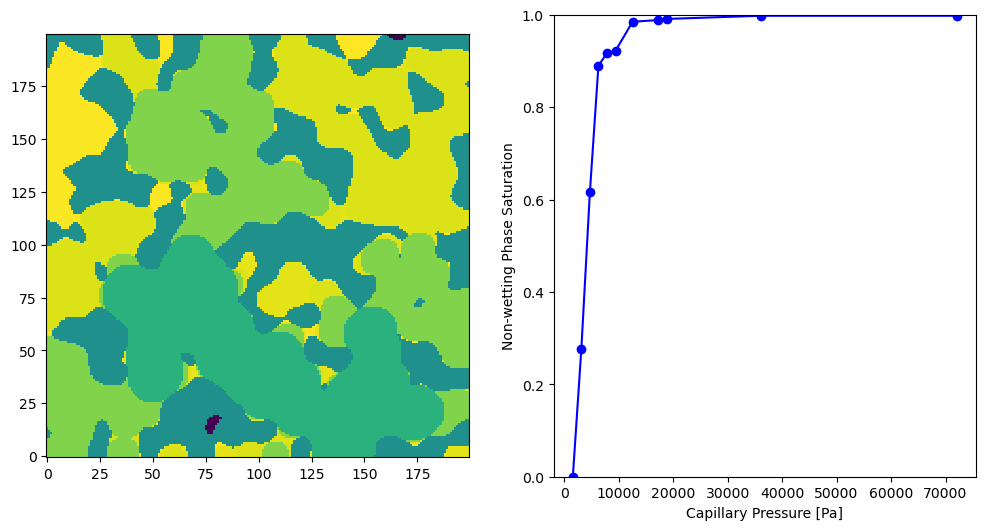

In [24]:
fig, ax = plt.subplots(1, 2, figsize=[12, 6])
ax[0].imshow(mip.im_satn, origin='lower', interpolation='none')
ax[1].plot(mip.pc, mip.snwp, 'b-o')
ax[1].set_ylim([0, 1.0])
ax[1].set_xlabel('Capillary Pressure [Pa]')
ax[1].set_ylabel('Non-wetting Phase Saturation');

### Obtaining Fluid Configurations
---
The ``im_satn`` array returned by the ``drainage`` function is designed so that all fluid configurations are contained in the same image. This means that the fluid configuration for a desired saturation can be obtained quickly as follows:

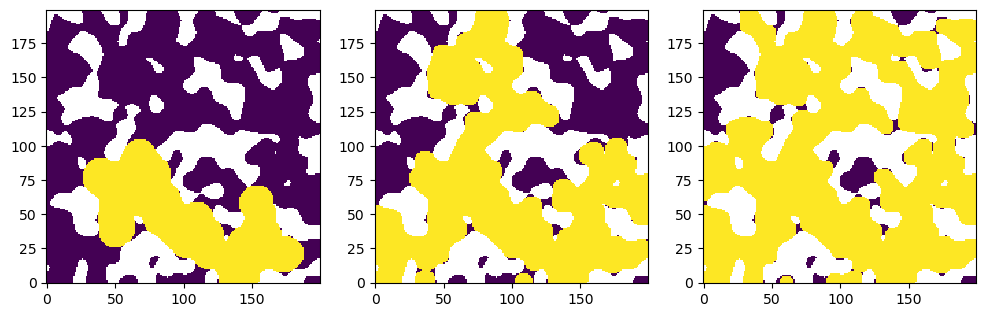

In [25]:
s1 = (mip.im_satn < 0.3) * (mip.im_satn >= 0)
s2 = (mip.im_satn < 0.7) * (mip.im_satn >= 0)
s3 = (mip.im_satn < 0.9) * (mip.im_satn >= 0)

fig, ax = plt.subplots(1, 3, figsize=[12, 6])
ax[0].imshow(s1/im, origin='lower', interpolation='none')
ax[1].imshow(s2/im, origin='lower', interpolation='none')
ax[2].imshow(s3/im, origin='lower', interpolation='none');

### Background Simulating Drainage

Like the local thickness filter, the drainage simulation is done by progressively adding smaller spheres, but there is one difference: any spheres not connected to the inlet are removed.  This is outlined below:

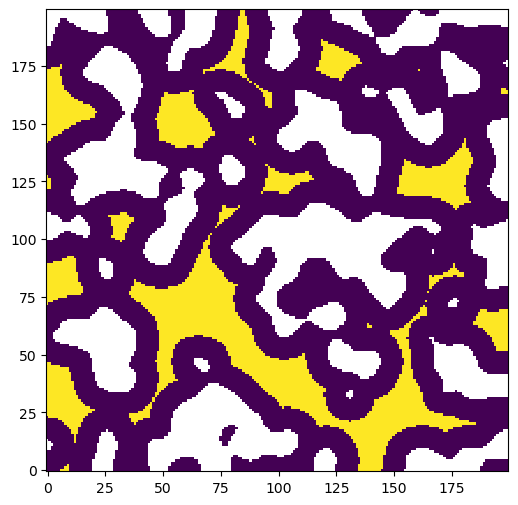

In [26]:
from edt import edt
dt = edt(im)
fig, ax = plt.subplots(figsize=[6, 6])
ax.imshow((dt > 10)/im, origin='lower', interpolation='none');

Each yellow voxel is a location where a sphere of radius 10 *could* be drawn.  But before we do that we should trim voxels that are not connected to the inlets.

We can do this by:
- Creating an image with ``True`` values indicating the inlets
- Labeling the clusters
- Removing all voxels whose label does not appear in the inlets


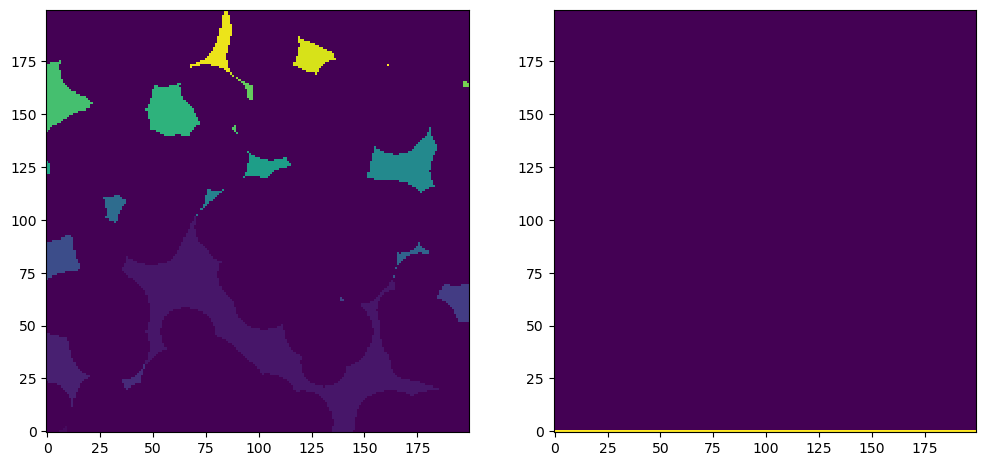

In [29]:
import scipy.ndimage as spim
labels, N = spim.label(dt > 10)
inlets = np.zeros_like(im)
inlets[0, :] = True

fig, ax = plt.subplots(1, 2, figsize=[12, 6])
ax[0].imshow(labels, origin='lower', interpolation='none')
ax[1].imshow(inlets, origin='lower', interpolation='none');

Using a bit of fancy logic and boolean masks, we can drop all voxels whose label number does not appear on the inlet:

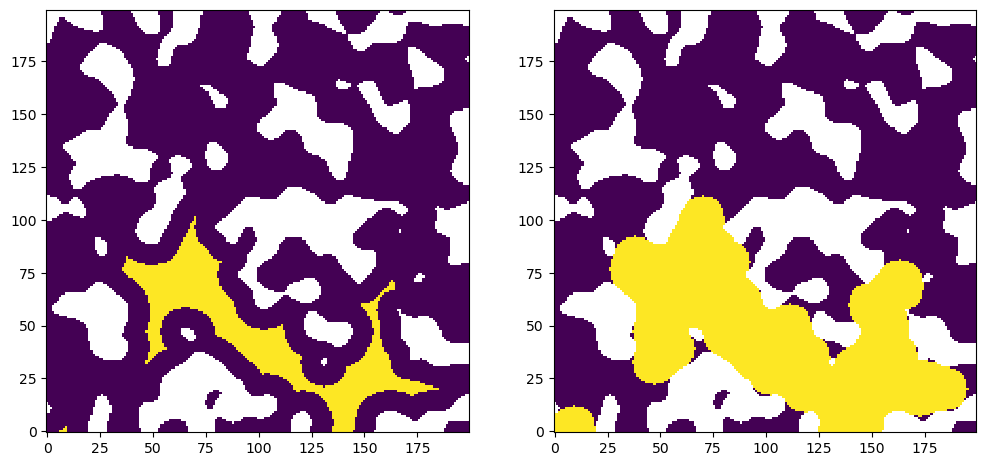

In [38]:
keep = np.isin(labels, labels[inlets])*(labels > 0)

fig, ax = plt.subplots(1, 2, figsize=[12, 6])
ax[0].imshow(keep/im, origin='lower', interpolation='none')
fluid = spim.binary_dilation(keep, structure=ps.tools.ps_round(10, ndim=2, smooth=False))
ax[1].imshow(fluid/im, origin='lower', interpolation='none');

## Mulitphase Flow Simulations

Aside from simulating capillary pressure curves for comparing to experimental data, the ``drainage`` algorithm can also be used to obtain fluid configurations corresponding to different saturations.  This can be used to compute relative effective diffusivity (or resistivity index).  

Given the fluid configuration computed above, let's find the effective diffusivity across the domain, perpendicular to the invasion face.

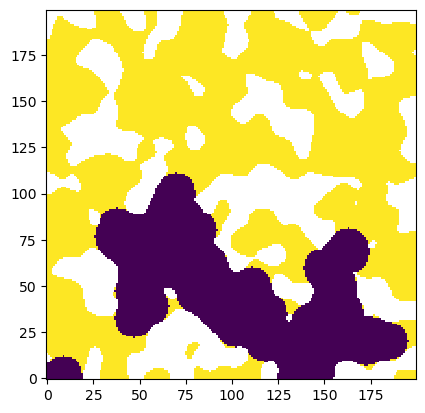

In [41]:
im2 = im*(~fluid)
plt.imshow(im2/im, origin='lower', interpolation='none')

Now lets apply ``tortuosity_fd`` along the y-axis:

[20:28:34] WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=283198;file://C:\Users\jeff\anaconda3\envs\porespy2\lib\site-packages\porespy\simulations\_dns.py\_dns.py]8;;\:]8;id=902684;file://C:\Users\jeff\anaconda3\envs\porespy2\lib\site-packages\porespy\simulations\_dns.py#70\70]8;;\

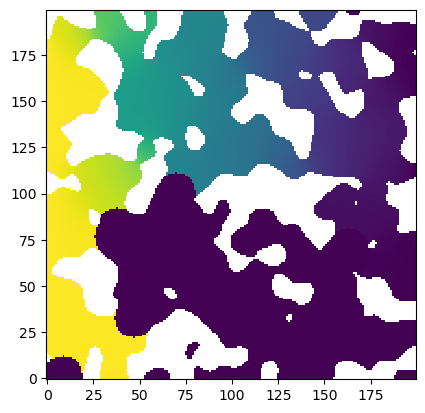

In [44]:
deff_y = ps.simulations.tortuosity_fd(im2, axis=1)
plt.imshow(deff_y.concentration/im, origin='lower', interpolation='none');

Let's print the ``deff_y`` object to see what the tortuosity was:

In [45]:
print(deff_y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Item                      Description
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im                        Image of size (200, 200)
tortuosity                2.828969370086357
formation_factor          6.342269633642769
original_porosity         0.490325
effective_porosity        0.44605
concentration             Image of size (200, 200)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Now let's check the ``tau_y`` object to see the tortuosity through the dry image:

In [46]:
print(tau_y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Item                      Description
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im                        Image of size (200, 200)
tortuosity                1.8336360644542187
formation_factor          2.596850395771447
original_porosity         0.7061
effective_porosity        0.7061
concentration             Image of size (200, 200)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


So the presence of the invading fluid increase the tortuosity by 50%.

> Note: This 'tortuosity' value is already account for the reduced pore volume due to the presence of invading fluid, so this a real increase in tortuosity, above and beyond the effect of just pore blockage.